In [2]:
import os, glob
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from typing import List

In [3]:
def compute_accuracy(preds_df, gold_column, pred_column):
    return preds_df.groupby('language')[[gold_column, pred_column]]\
        .apply(lambda x: (x[gold_column] == x[pred_column])\
               .mean())\
                .reset_index()\
                    .rename(columns={0: 'accuracy'})

In [4]:
def plot(df):
    topics = df.index
    languages = df.columns
    x = np.arange(len(topics))  # label locations
    width = 0.2  # bar width

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'de': 'indianred', 'fr': 'royalblue', 'it': 'seagreen'}

    # Plot bars for each language
    for i, lang in enumerate(languages):
        ax.bar(x + i * width, df[lang], width, color=colors[lang], label=lang)

    ax.set_xlabel("Topic")
    ax.set_ylabel("Accuracy")
    ax.set_title("Performance by Topic and Language")
    ax.set_xticks(x + width, topics, rotation=45, ha="right")
    ax.legend(loc='upper center', ncol=len(languages))
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

In [5]:
def plot_metrics(model_dir):
    last_ckpt = os.path.join(glob.glob(os.path.join(model_dir, 'checkpoint-*'))[-1], 'trainer_state.json')

    with open(last_ckpt, 'r') as file:
        data = json.load(file)

    log_history = (pd.DataFrame(data['log_history'])
                .groupby("epoch")
                .agg(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None)
                .reset_index())
    
    log_history.plot(x='epoch', 
                     y=['eval_accuracy', 'eval_loss', 'loss'], 
                     label=['Validation Accuracy', 'Validation Loss', 'Training Loss'], 
                     color=['green', 'red', 'maroon'], 
                     grid=True
                     )

In [6]:
from scipy.stats import norm

def wald_ci(p, n, confidence=0.95):
    """
    Computes a confidence interval using the Gaussian (Wald) method.

    Args:
        p (float): Proportion of errors (or any rate being measured).
        n (int): Sample size.
        confidence (float): Confidence level (default is 0.95 for 95% CI).

    Returns:
        str: Confidence interval as a formatted string "[lower, upper]".
    """
    if n == 0:
        return "[0, 0]"
    
    z = norm.ppf(1 - (1 - confidence) / 2)  # Compute z-score dynamically
    se = np.sqrt(p * (1 - p) / n)  # Standard error
    lower = max(0, p - z * se)  # Clamp at 0 to avoid negative proportions
    upper = min(1, p + z * se)  # Clamp at 1 to avoid >100% values
    
    return f"[{round(lower * 100, 2)}, {round(upper * 100, 2)}]"

def analyze_errors(df, gold_column, pred_column, group_cols, confidence=0.95, compute_ci=False):
    """
    Analyzes prediction errors by language, computing error rates and (optional) confidence intervals.
    """
    def compute_stats(group):
        n = len(group)
        err_rate = np.mean(group[gold_column] != group[pred_column])
        fp_rate = np.mean((group[gold_column] == 'AGAINST') & (group[pred_column] == 'FAVOR'))
        fn_rate = np.mean((group[gold_column] == 'FAVOR') & (group[pred_column] == 'AGAINST'))

        result = {
            'ErrRate (%)': round(err_rate * 100, 2),
            'FP (%)': round(fp_rate * 100, 2),
            'FN (%)': round(fn_rate * 100, 2)
        }

        if compute_ci:
            result.update({
                'ErrRate_CI': wald_ci(err_rate, n, confidence),
                'FP_CI': wald_ci(fp_rate, n, confidence),
                'FN_CI': wald_ci(fn_rate, n, confidence)
            })
        
        return pd.Series(result)
    
    return df.groupby(group_cols)[[gold_column, pred_column]].apply(compute_stats).reset_index()

In [7]:
def balance_df(df, columns:List, rs=42):
    # minimum count of rows for any combination of values in the specified columns
    min_count = df.groupby(columns).size().min()
    
    # sample min_count rows for each column combination
    balanced_df = (
        df.groupby(columns)
          .apply(lambda group: group.sample(min_count, random_state=rs))
          .reset_index(drop=True)
    )
    
    return balanced_df.sample(frac=1).reset_index(drop=True)    # shuffle the rows

---

## Determining Topic Controversy in the Dataset

<Axes: title={'center': 'Number of Questions per Topic'}, ylabel='topic'>

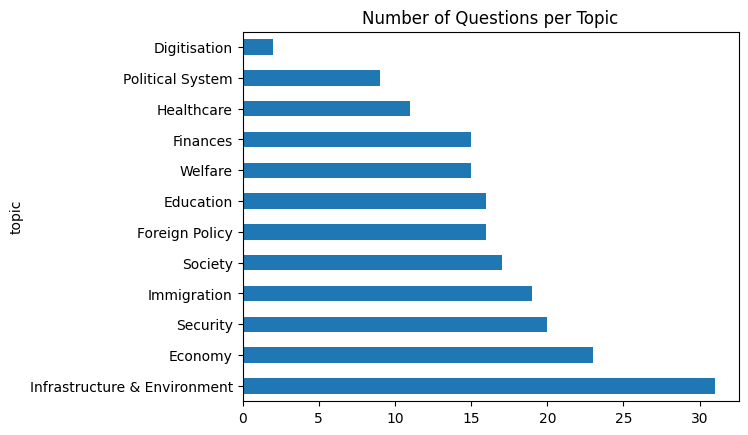

In [8]:
questions_en = pd.read_json('../data/xstance/questions.en.jsonl', lines=True)
questions_en['topic'].value_counts().plot(kind='barh', title='Number of Questions per Topic')

<Axes: title={'center': 'Number of Comments per Topic'}, ylabel='topic'>

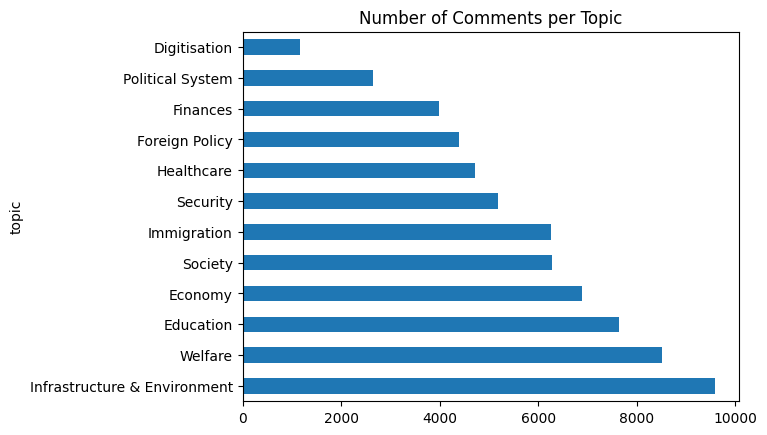

In [9]:
train = pd.read_json('../data/xstance/train.jsonl', lines=True)
valid = pd.read_json('../data/xstance/valid.jsonl', lines=True)
test = pd.read_json('../data/xstance/test.jsonl', lines=True)
all_data = pd.concat([train, valid, test])
all_data['topic'].value_counts().plot(kind='barh', title='Number of Comments per Topic')

<Axes: title={'center': 'Topic Controversy'}, ylabel='topic'>

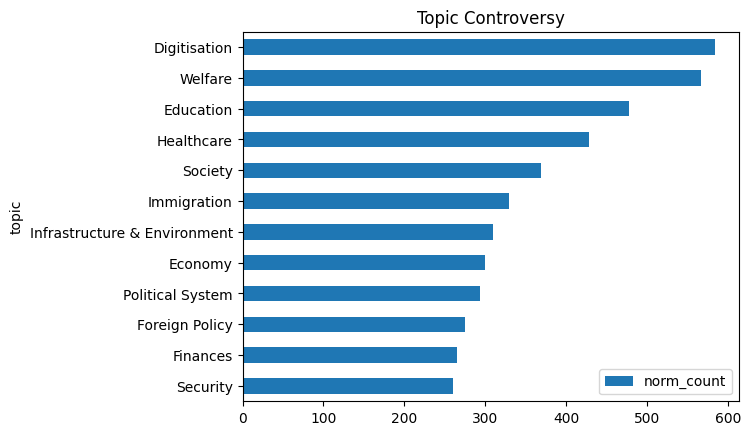

In [10]:
topic_q_counts = questions_en['topic'].value_counts().reset_index().rename(columns={'count': 'q_count'})
topic_cm_counts = all_data['topic'].value_counts().reset_index().rename(columns={'count': 'cm_count'})
topic_norm_counts = pd.merge(topic_q_counts, topic_cm_counts, on='topic').assign(norm_count=lambda x: round(x['cm_count'] / x['q_count'], 2)).sort_values('norm_count')
topic_norm_counts.plot(kind='barh', x='topic', y='norm_count', title='Topic Controversy')

<Axes: title={'center': 'Number of comments per question'}, xlabel='question_id'>

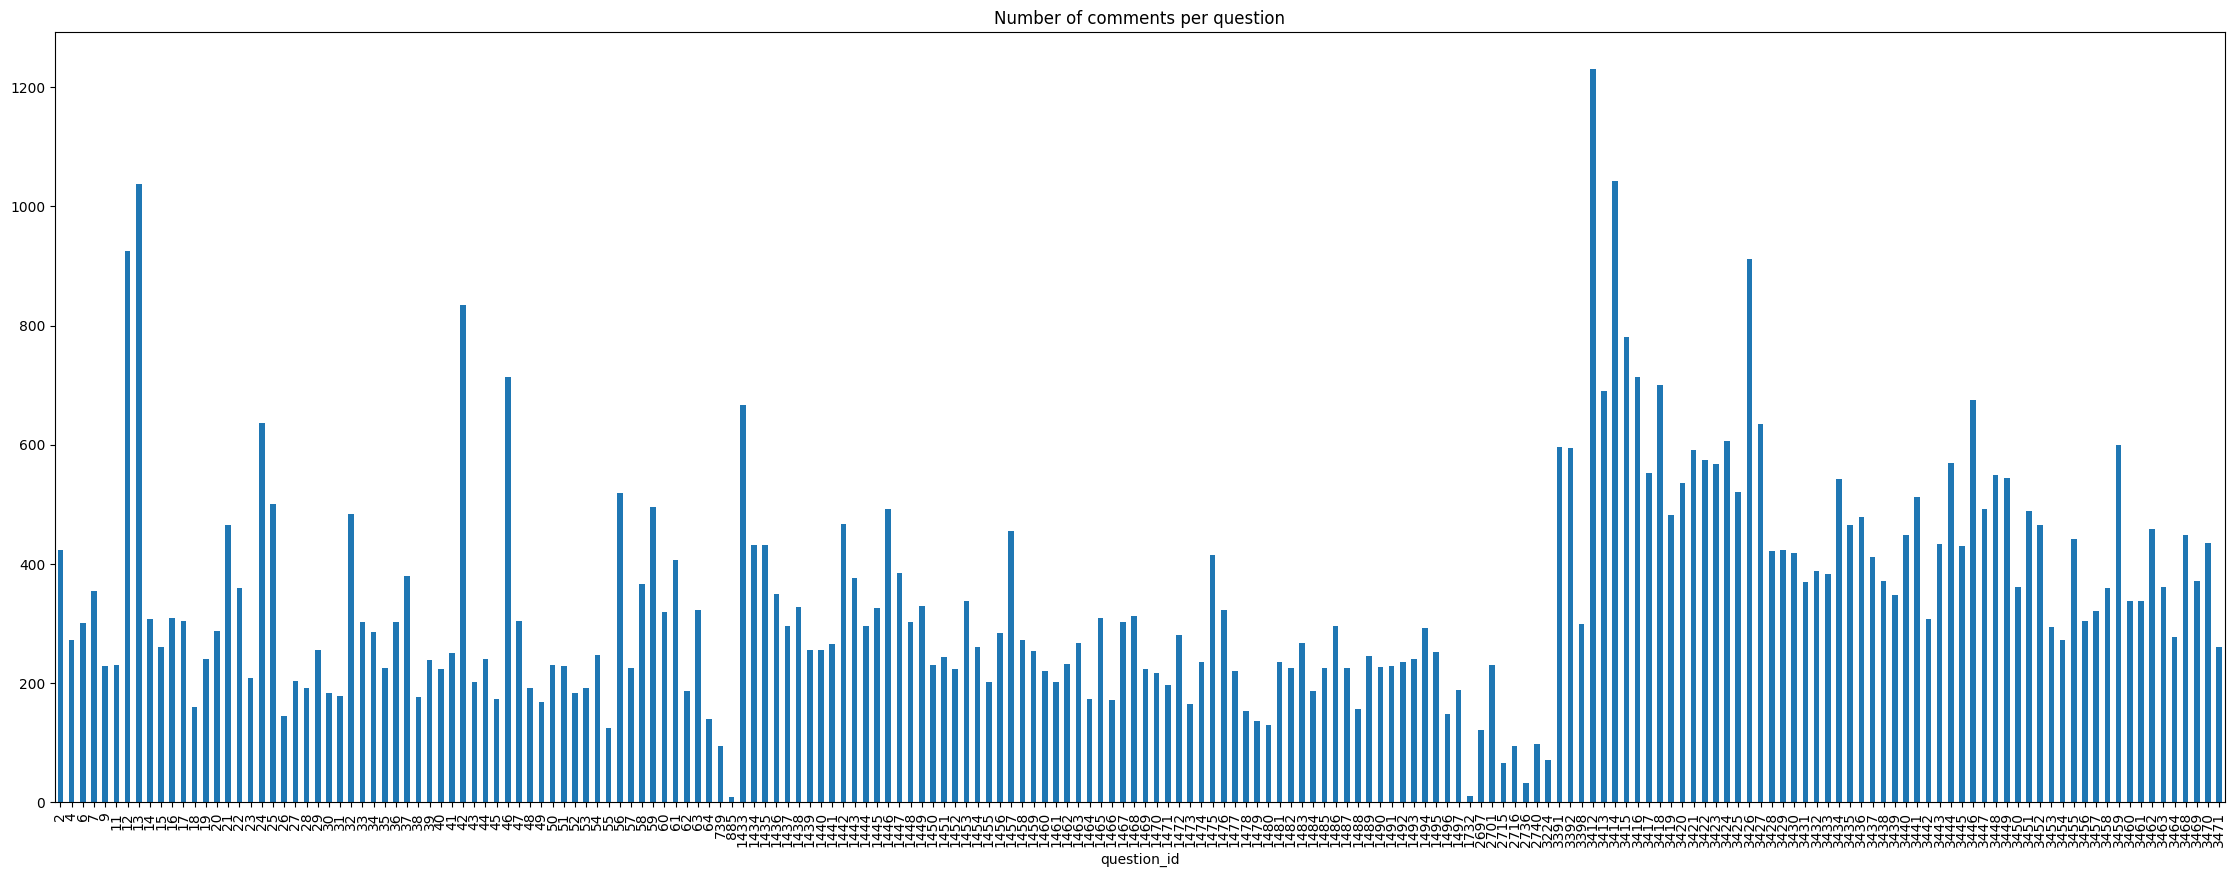

In [11]:
all_data.groupby('question_id')['comment'].count().plot(kind='bar', figsize=(28, 10), title="Number of comments per question")

In [12]:
all_data.groupby(['question_id', 'topic']).agg(
    n_FAVOR=('label', lambda x: (x == 'FAVOR').sum()),
    n_AGAINST = ('label', lambda x : (x == 'AGAINST').sum())
).reset_index()

,question_id,topic,n_FAVOR,n_AGAINST
0,2,Welfare,303,120
1,4,Welfare,144,128
2,6,Welfare,121,179
3,7,Healthcare,198,157
4,9,Healthcare,118,110
...,...,...,...,...
189,3464,Security,173,105
190,3468,Foreign Policy,138,311
191,3469,Foreign Policy,209,162
192,3470,Foreign Policy,246,189


---
## Binary

### Baseline

In [13]:
vanilla_xlmr_preds = pd.read_csv('../predictions/vanilla_XLM-R_preds.csv')
vanilla_xlmr_acc = compute_accuracy(vanilla_xlmr_preds, 'label', 'prediction')    # accuracy of always predicting 'AGAINST'

### Fine-tuned

In [14]:
# model_dir = "../models/binary_stance_classifier/"
# plot_metrics(model_dir)

In [15]:
# Only comments
# test_preds = pd.read_csv('../../predictions/xstance_test_preds_finetuned.csv')
# compute_accuracy(test_preds, 'label', 'prediction')

In [16]:
# Questions + comments
ft_preds = pd.read_csv('../predictions/xlmr+xstance_preds.csv')
ft_acc = compute_accuracy(ft_preds, 'label', 'prediction')

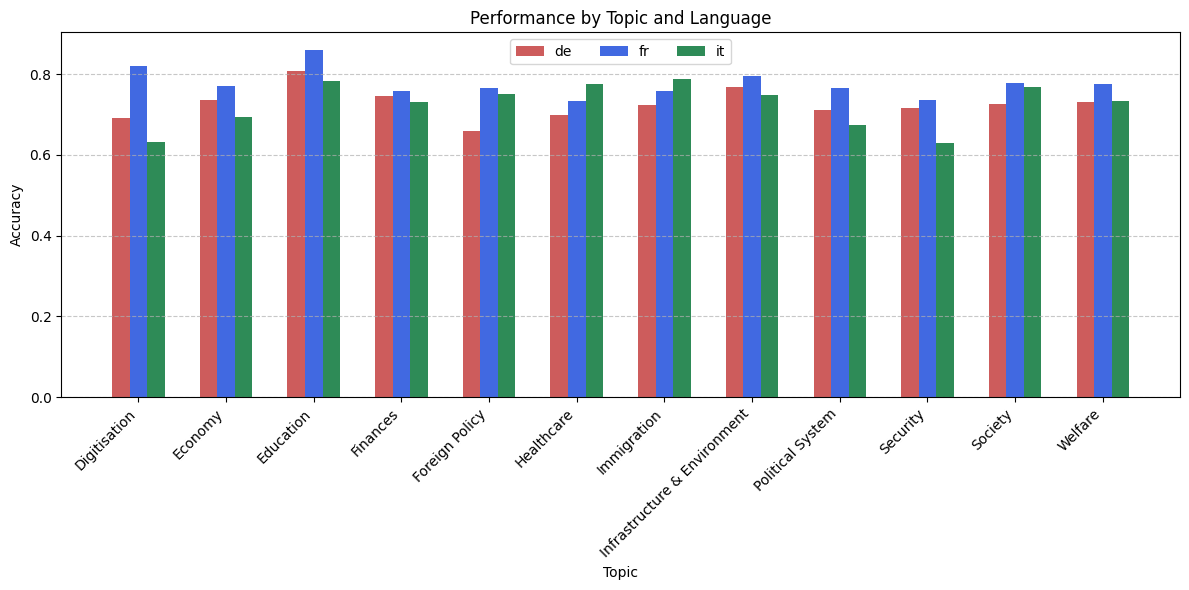

In [17]:
ft_preds_by_topics = ft_preds.groupby(['topic', 'language'])[['label', 'prediction']]\
    .apply(lambda x: (x['label'] == x['prediction']).mean())\
    .reset_index()\
    .pivot(index='topic', columns='language', values=0)

plot(ft_preds_by_topics)

### Translated

In [39]:
de2fr_preds = pd.read_csv('../predictions/de2fr_preds.csv')
de2fr_acc = compute_accuracy(de2fr_preds, 'label', 'prediction')

fr2de_preds = pd.read_csv('../predictions/fr2de_preds.csv')
fr2de_acc = compute_accuracy(fr2de_preds, 'label', 'prediction')

it2fr_preds = pd.read_csv('../predictions/it2fr_preds.csv')
it2fr_acc = compute_accuracy(it2fr_preds, 'label', 'prediction')

it2de_preds = pd.read_csv('../predictions/it2de_preds.csv')
it2de_acc = compute_accuracy(it2de_preds, 'label', 'prediction')

translated_acc = pd.concat([de2fr_acc, fr2de_acc, it2fr_acc, it2de_acc]).reset_index(drop=True).rename(columns={'accuracy': 'acc_trans'})

In [40]:
de2fr2de_preds = pd.read_csv('../predictions/de2fr2de_preds.csv')
de2fr2de_acc = compute_accuracy(de2fr2de_preds, 'label', 'prediction').assign(trans_description='German → French → German')

fr2de2fr_preds = pd.read_csv('../predictions/fr2de2fr_preds.csv')
fr2de2fr_acc = compute_accuracy(fr2de2fr_preds, 'label', 'prediction').assign(trans_description='French → German → French')

it2fr2it_preds = pd.read_csv('../predictions/it2fr2it_preds.csv')
it2fr2it_acc = compute_accuracy(it2fr2it_preds, 'label', 'prediction').assign(trans_description='Italian → French → Italian')

it2de2it_preds = pd.read_csv('../predictions/it2de2it_preds.csv')
it2de2it_acc = compute_accuracy(it2de2it_preds, 'label', 'prediction').assign(trans_description='Italian → German → Italian')

round_trans_preds = pd.concat([de2fr2de_preds, fr2de2fr_preds, it2fr2it_preds, it2de2it_preds])
round_translated_acc = pd.concat([de2fr2de_acc, fr2de2fr_acc, it2fr2it_acc, it2de2it_acc]).reset_index(drop=True).rename(columns={'accuracy': 'acc_round-trans'})

In [41]:
joint_trans = pd.concat([translated_acc, round_translated_acc.drop(columns=['language'])], axis=1)

In [42]:
# All accuracies

bi_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    vanilla_xlmr_acc.rename(columns={'accuracy': 'acc_base'}),
    ft_acc.rename(columns={'accuracy': 'acc_ft'}),
    joint_trans
])

bi_acc

,language,acc_base,acc_ft,acc_trans,acc_round-trans,trans_description
0,de,0.494660,0.723825,0.670171,0.663863,German → French → German
1,fr,0.456502,0.765797,0.695284,0.692079,French → German → French
2,it,0.460581,0.735823,0.727524,0.690871,Italian → French → Italian
3,it,0.460581,0.735823,0.691563,0.677732,Italian → German → Italian


### Error Analysis
**Question:** How many times has the stance changed and in which direction?

In [43]:
ft_err_rates = analyze_errors(ft_preds, 'label', 'prediction', group_cols='language', compute_ci=True)
ft_err_rates

,language,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI
0,de,27.62,14.19,13.43,"[26.81, 28.42]","[13.56, 14.81]","[12.82, 14.04]"
1,fr,23.42,12.71,10.71,"[22.16, 24.68]","[11.72, 13.69]","[9.8, 11.63]"
2,it,26.42,13.83,12.59,"[24.15, 28.69]","[12.05, 15.61]","[10.88, 14.3]"


In [46]:
de2fr_err = analyze_errors(de2fr_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='German → French')
fr2de_err = analyze_errors(fr2de_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='French → German')
it2fr_err = analyze_errors(it2fr_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='Italian → French')
it2de_err = analyze_errors(it2de_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='Italian → German')

trans_err_rates = pd.concat([de2fr_err, fr2de_err, it2fr_err, it2de_err]).reset_index(drop=True)
trans_err_rates

,language,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,trans_description
0,de,32.98,18.55,14.43,"[32.14, 33.83]","[17.85, 19.25]","[13.8, 15.06]",German → French
1,fr,30.47,17.35,13.12,"[29.11, 31.84]","[16.23, 18.48]","[12.12, 14.12]",French → German
2,it,27.25,14.45,12.79,"[24.95, 29.54]","[12.64, 16.27]","[11.07, 14.52]",Italian → French
3,it,30.84,16.18,14.66,"[28.46, 33.22]","[14.28, 18.08]","[12.84, 16.48]",Italian → German


In [47]:
de2fr2de_err = analyze_errors(de2fr2de_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='German → French → German')
fr2de2fr_err = analyze_errors(fr2de2fr_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='French → German → French')
it2fr2it_err = analyze_errors(it2fr2it_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='Italian → French → Italian')
it2de2it_err = analyze_errors(it2de2it_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='Italian → German → Italian')

round_trans_err_rates = pd.concat([de2fr2de_err, fr2de2fr_err, it2fr2it_err, it2de2it_err]).reset_index(drop=True)
round_trans_err_rates

,language,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,trans_description
0,de,33.61,18.80,14.82,"[32.76, 34.46]","[18.09, 19.5]","[14.18, 15.46]",German → French → German
1,fr,30.79,16.96,13.83,"[29.42, 32.16]","[15.85, 18.08]","[12.8, 14.85]",French → German → French
2,it,30.91,17.77,13.14,"[28.53, 33.29]","[15.8, 19.74]","[11.4, 14.88]",Italian → French → Italian
3,it,32.23,19.50,12.72,"[29.82, 34.64]","[17.46, 21.54]","[11.01, 14.44]",Italian → German → Italian


In [49]:
ft_err = analyze_errors(ft_preds, 'label', 'prediction', group_cols=['question_id', 'topic'], compute_ci=True)
high_err_rate_ft = ft_err[ft_err['ErrRate (%)'] > 50]
n_comments = test[test['question_id'].isin(high_err_rate_ft['question_id'])].groupby('question_id')['comment'].count().reset_index().rename(columns={'comment': 'n_comments'})
high_err_rate_ft = pd.merge(high_err_rate_ft, n_comments, on='question_id')
high_err_rate_ft

,question_id,topic,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,n_comments
0,54,Security,52.94,26.47,26.47,"[36.16, 69.72]","[11.64, 41.3]","[11.64, 41.3]",34
1,1488,Security,52.63,36.84,15.79,"[30.18, 75.08]","[15.15, 58.53]","[0, 32.19]",19
2,1490,Security,54.17,0.00,54.17,"[34.23, 74.1]","[0, 0.0]","[34.23, 74.1]",24


In [51]:
rt_err = analyze_errors(round_trans_preds, 'label', 'prediction', group_cols=['question_id', 'topic'], compute_ci=True)
high_err_rate_rt = rt_err[rt_err['ErrRate (%)'] > 50]
n_comments = test[test['question_id'].isin(high_err_rate_rt['question_id'])].groupby('question_id')['comment'].count().reset_index().rename(columns={'comment': 'n_comments'})
high_err_rate_rt = pd.merge(high_err_rate_rt, n_comments, on='question_id')
high_err_rate_rt

,question_id,topic,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,n_comments
0,6,Welfare,54.29,37.14,17.14,"[37.78, 70.79]","[21.14, 53.15]","[4.66, 29.63]",29
1,26,Society,57.14,39.29,17.86,"[38.81, 75.47]","[21.2, 57.38]","[3.67, 32.04]",22
2,54,Security,53.49,23.26,30.23,"[38.58, 68.4]","[10.63, 35.88]","[16.51, 43.96]",34
3,1487,Security,54.29,28.57,25.71,"[37.78, 70.79]","[13.61, 43.54]","[11.23, 40.19]",28
4,1490,Security,55.17,6.90,48.28,"[37.07, 73.27]","[0, 16.12]","[30.09, 66.46]",24


In [29]:
# Accuracy of the back_translated inputs with respect to the finetuned model predictions
back_trans_preds = pd.concat([de2fr2de_preds, fr2de2fr_preds, it2fr2it_preds])
back_trans_preds = pd.merge(back_trans_preds, ft_preds[['id', 'prediction']].rename(columns={'prediction': 'ft_preds'}), on='id')
back_trans_acc_wrt_ft_acc = compute_accuracy(back_trans_preds, 'ft_preds', 'prediction')
back_trans_acc_wrt_ft_acc

,language,accuracy
0,de,0.737869
1,fr,0.757784
2,it,0.779391


In [30]:
# Cases where the back-translated predictions differ from the fine-tuned predictions
errors_wrt_ft = back_trans_preds[back_trans_preds['prediction'] != back_trans_preds['ft_preds']]
print('Where the back-translated predictions differ from the fine-tuned predictions,')

# Number of times the back-translated predictions were correct:
bt_correct = errors_wrt_ft[errors_wrt_ft['prediction'] == errors_wrt_ft['label']]
print('Number of times the back-translated predictions were correct:', len(bt_correct))

# Number of times the fine-tuned predictions were correct:
ft_correct = errors_wrt_ft[errors_wrt_ft['ft_preds'] == errors_wrt_ft['label']]
print('Number of times the fine-tuned predictions were correct:', len(ft_correct))

Where the back-translated predictions differ from the fine-tuned predictions,
Number of times the back-translated predictions were correct: 1697
Number of times the fine-tuned predictions were correct: 2797


In [31]:
for _, row in bt_correct[bt_correct['language'] == 'fr'].sample(5).iterrows():
    print(f"Original question: {test[test['id'] == row['id']]['question'].iloc[0]}")
    print(f"Original comment: {test[test['id'] == row['id']]['comment'].iloc[0]}")
    print(f"Back-translated question: {row['question']}")
    print(f"Back-translated comment: {row['comment']}")
    print(f"True label: {row['label']}")
    print(f"Finetuned model prediction: {row['ft_preds']}")
    print(f"Back-translated model prediction: {row['prediction']}")
    print()

Original question: Est-il nécessaire de fermer davantage d’hôpitaux en Suisse pour réduire les coûts de la santé?
Original comment: La réduction des coûts de santé doit passer par une meilleure hygiène de vie chez certains groupes de personnes.
Back-translated question: Est-il nécessaire de fermer plus d'hôpitaux en Suisse pour réduire les coûts de santé?
Back-translated comment: La réduction des coûts de santé doit être réalisée par une meilleure hygiène de vie dans certains groupes de personnes.
True label: AGAINST
Finetuned model prediction: FAVOR
Back-translated model prediction: AGAINST

Original question: L'introduction du vote électronique lors des votations et des élections (E-Voting) devrait-elle être poursuivie?
Original comment: Surtout les Suisses de l'étranger qui, de fait, peuvent rarement voter.
Back-translated question: Le vote électronique devrait-il continuer à être introduit lors des élections et des élections ?
Back-translated comment: Les Suisses étrangers, en part

In [32]:
for _, row in ft_correct[ft_correct['language'] == 'fr'].sample(5).iterrows():
    print(f"Original question: {test[test['id'] == row['id']]['question'].iloc[0]}")
    print(f"Original comment: {test[test['id'] == row['id']]['comment'].iloc[0]}")
    print(f"Back-translated question: {row['question']}")
    print(f"Back-translated comment: {row['comment']}")
    print(f"True label: {row['label']}")
    print(f"Finetuned model prediction: {row['ft_preds']}")
    print(f"Back-translated model prediction: {row['prediction']}")
    print()

Original question: Seriez-vous favorables à un plan hospitalier national qui pourrait également mener à la fermeture de certains hôpitaux?
Original comment: Cette question est mal tournée, car il faut savoir s'il s'agit d'hôpitaux publics ou privés. Moi je suis pour la préservation d'un service de santé public de bonne qualité et de proximité, accessible à tout en chacun, la santé n'est pas une marchandise de luxe, c'est un doit pour tous.
Back-translated question: Soutiendrez-vous un plan national d'hôpitaux qui pourrait également entraîner la fermeture de certains hôpitaux?
Back-translated comment: La Commission estime que la Commission a la possibilité d'aider les États membres, les États membres et les États membres qui sont utilisés dans leur cadre pour mettre en œuvre la directive sur les soins de santé et les soins de santé de protection de la santé.
True label: AGAINST
Finetuned model prediction: AGAINST
Back-translated model prediction: FAVOR

Original question: Une initiative

### Control for Topic

In [ ]:
# ub_preds = pd.read_csv('../predictions/ub_preds.csv')
# filtered_train = pd.read_json('../data/xstance/filtered_train.jsonl', lines=True)
# ub_preds = ub_preds[ub_preds['topic'].isin(filtered_train['topic'].unique())]

# ub_acc = compute_accuracy(ub_preds, 'label', 'prediction')

# ub_bal = balance_df(ub_preds, ['language', 'label'])
# ub_bal_acc = compute_accuracy(ub_bal, 'label', 'prediction')

---
## Multi-class

### Baseline

In [39]:
multi_base_preds = pd.read_csv('../predictions/multi_baseline_preds.csv')
multi_base_acc = compute_accuracy(multi_base_preds, 'numerical_label', 'prediction')

### Fine-tuned

In [40]:
# Micro Average
# model_dir = "../models/multi_micro_stance_classifier/"
# plot_metrics(model_dir)

In [41]:
multi_micro_preds = pd.read_csv('../predictions/multi_micro_preds.csv')
multi_micro_acc = compute_accuracy(multi_micro_preds, 'numerical_label', 'prediction')

In [42]:
# Macro Average
# model_dir = "../models/multi_macro_stance_classifier/"
# plot_metrics(model_dir)

In [43]:
multi_macro_preds = pd.read_csv('../predictions/multi_macro_preds.csv')
multi_macro_acc = compute_accuracy(multi_macro_preds, 'numerical_label', 'prediction')

In [44]:
# All accuracies

multi_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    multi_base_acc.rename(columns={'accuracy': 'baseline'}),
    multi_micro_acc.rename(columns={'accuracy': 'finetuned_MicroAvg'}),
    multi_macro_acc.rename(columns={'accuracy': 'finetuned_MacroAvg'})
])
multi_acc

,language,baseline,finetuned_MicroAvg,finetuned_MacroAvg
0,de,0.282062,0.503574,0.494660
1,fr,0.304945,0.543040,0.523352
2,it,0.269018,0.508299,0.499308
